In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

In [2]:
# Out-of-fold prediction files are saved in folder 'Out-of-fold predictions'
paths = ['oof_lgbm_baseline_5fold_seed42_l2_5_1258fe_round2_9500_new.csv'
        ,'oof_lgbm_baseline_5fold_seed42_l2_5_1258fe_round2_9500_ff25.csv'
        ,'oof_xgb_0796_kaggle.csv'
        ]

In [3]:
# Create a dataframe
oof_df = pd.DataFrame()

for i, path in enumerate(paths):
    
    # Find filename
    start = 0
    end = path.find('.csv')
    fname = path[start:end]
    
    print(f'model {i+1} is: {fname}')
    
    temp = pd.read_csv(path)
    
    # Set column name of oof
    temp.rename(columns={'prediction': f'model {i+1}'}, inplace=True)
    
    # Drop redundant target column
    if i != 0:
        temp.drop(columns=['target'], inplace=True)
    
    # Join to main file
    if i == 0:
        oof_df = temp
    else:
        oof_df = pd.merge(oof_df, temp, on="customer_ID", how="left")
    
oof_df.shape

model 1 is: oof_lgbm_baseline_5fold_seed42_l2_5_1258fe_round2_9500_new
model 2 is: oof_lgbm_baseline_5fold_seed42_l2_5_1258fe_round2_9500_ff25
model 3 is: oof_xgb_0796_kaggle


(458913, 5)

In [4]:
oof_df.head()

,customer_ID,target,model 1,model 2,model 3
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000465,0.000445,0.000304
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.000739,0.000673,0.000663
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.000714,0.001037,0.000917
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.003782,0.003708,0.004145
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.001533,0.001437,0.000982


In [5]:
plot_fe = [col for col in oof_df.columns if col not in ['target','customer_ID']]

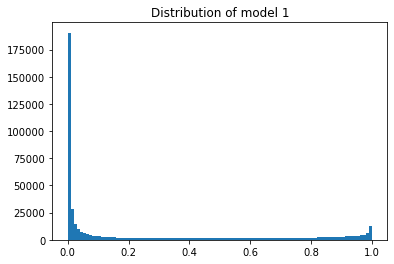

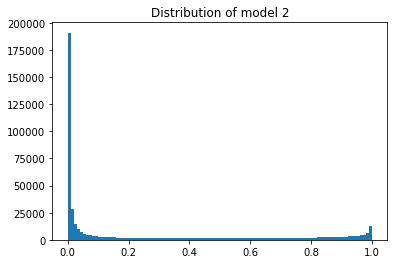

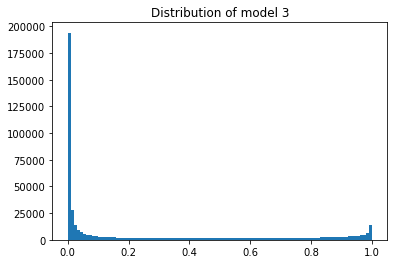

In [6]:
import matplotlib.pyplot as plt
for fe in plot_fe:
    plt.hist(oof_df[fe], bins=100)
    plt.title(f'Distribution of {fe}')
    plt.show()

In [7]:
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [8]:
# Compute amex score for each oof prediction
oofCols = [col for col in oof_df.columns if 'model' in col]

for col in oofCols:
    metric = amex_metric_mod(oof_df['target'], oof_df[col])
    
    print(f"{col} has amex score : {metric}")

model 1 has amex score : 0.7984637138546473
model 2 has amex score : 0.7980616411230783
model 3 has amex score : 0.7967728512767829


# **Optimised weights**

In [ ]:
# Find best weights that have the highest oof cv score
%%time
oof_preds = []
for col in oofCols:
    print(col)
    oof_preds.append(oof_df[col])

score = 0
for i in range(0,101):
    for j in range(0,101):
        w1 = i * 0.01
        w2 = j * 0.01
        if w1 + w2 < 1:
            w3 = 1- w1 - w2
            y_avg = (np.array(oof_preds)[0]*w1)+(np.array(oof_preds)[1]*w2)+(np.array(oof_preds)[2]*w3)
            sa_metric = amex_metric_mod(oof_df['target'], y_avg)
            if sa_metric > score:
                score = sa_metric
                fw1 = w1
                fw2 = w2
                fw3 = w3
print(f"Average: {score}, weights are: {fw1, fw2, fw3}")

In [12]:
# Compute cv score of an ensemble with optimised weights
oof_preds_check = []
for col in oofCols:
    oof_preds_check.append(oof_df[col])
    
y_avg = (np.array(oof_preds_check)[0]*0.38)+(np.array(oof_preds_check)[1]*0.49)+(np.array(oof_preds_check)[2]*0.13)
sa_metric = amex_metric_mod(oof_df['target'], y_avg)
print(sa_metric)

0.7995637162116731


# **Ensembling**

In [13]:
# Load predictions of each single model
# The predictions of each single model are saved in folder 'Single model predictions'
csv1 = pd.read_csv('test_lgbm_5folds_seed42_l2_5_1258fe_round2_9500_new.csv')
csv2 = pd.read_csv('test_lgbm_5folds_seed42_l2_5_1258fe_round2_9500_ff25.csv')
csv3 = pd.read_csv('submission_0796_kaggle.csv')
csv_final = csv1.copy()
csv_final['prediction'] = (csv1['prediction']*0.38)+(csv2['prediction']*0.49)+(csv3['prediction']*0.13)

In [14]:
csv_final.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.055024
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.006757
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.064389
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.217761
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.880862


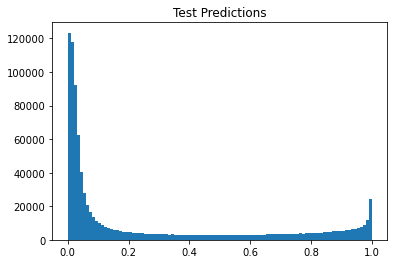

In [15]:
import matplotlib.pyplot as plt
plt.hist(csv_final.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

In [ ]:
#csv_final.to_csv('submission_real_final.csv', index=False)